In [1]:
from google.colab import files
files.upload() # kaggle.jsonをアップロード
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


  0% 0.00/346k [00:00<?, ?B/s]
100% 346k/346k [00:00<00:00, 50.9MB/s]
Archive:  speeddating.zip
  inflating: speed-dating.csv        


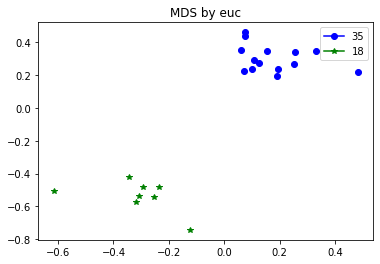

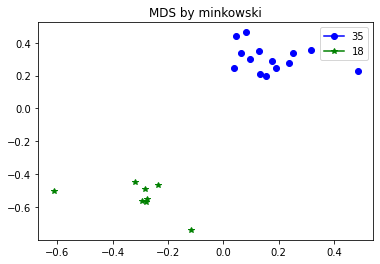

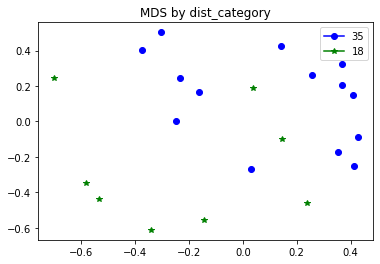

In [8]:
import pandas as pd
import numpy as np
import math
# ユークリッド距離およびミンコフスキー距離を
# 使用するためにインポート
import scipy.spatial.distance as dist
# 多次元尺度構成法を用いるためにインポート
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
%matplotlib inline
# ユークリッド距離
def euc(X1, X2):
    return np.linalg.norm( X1 - X2 )
# ミンコフスキー距離
def minkowski(X1, X2):
    return dist.minkowski(X1, X2, p=3)
# カテゴリ特徴量の一致に基づく距離
def dist_category(X1, X2):
    dist = 0.0
    for i in range(len(X1)):
        if X1[i] == 'NULL' and X2[i] == 'NULL':
            dist += 1.0
        if X1[i] != X2[i]:
            dist += 1.0
    return math.sqrt(dist)

# 距離行列を作成する
def calc_dist_matrix( X, distfunc ):
    mat = []
    for i in range(len(X)):
        mat.append([])
        for j in range(len(X)):
            if i == j:
                mat[i].append(0.0)
                continue
            d = distfunc(X[i], X[j])
            mat[i].append(d) 
    return mat

# 距離行列をもとにMDSによる2次元空間への配置
def makeGraphMDS(mat, cls, dist_type, ages):
    mds = MDS(n_components=2, dissimilarity='precomputed',
              random_state=2, metric=False) 
    pos = mds.fit_transform(mat)
    plt.figure()
    lbs = ages
    mks = ['*','o']
    cols = ['green','blue']
    chk = [0] * len(mks)
    # MDSによりデータの配置を行う
    for l, x, y in zip(cls, pos[:,0], pos[:,1]):
        li = lbs.index(l)
        if chk[li] == 0:
            plt.plot(x, y, \
              marker=mks[li], label=lbs[li], color=cols[li])
            chk[li]=1
        else:
            plt.plot(x, y, marker=mks[li], color=cols[li])
    plt.title('MDS by {}'.format(dist_type))
    plt.legend()
    plt.savefig('MDS_{}.png'.format(dist_type), dpi=400)
    plt.show()

# データの読み込み
!kaggle datasets download -d somesh24/speeddating
!unzip speeddating.zip
df = pd.read_csv('speed-dating.csv')

# 欠損値をもつデータを除外
df = df[df['has_null']==0]
# 19歳と35歳のみを対象とする
ages=[18,35]
df = df[df['age'].isin(ages)]
df=df[df.notnull().any(axis=1)]
# 使用する特徴量
features = ['wave', 'age_o','d_age',
            'samerace', 'importance_same_race', 
            'importance_same_religion', 'pref_o_attractive',
            'pref_o_sincere', 'pref_o_intelligence',
            'pref_o_funny', 'pref_o_ambitious',
            'pref_o_shared_interests', 'attractive_o',
            'sinsere_o', 'intelligence_o',
            'funny_o', 'ambitous_o', 'shared_interests_o',
            'attractive_important', 'sincere_important', 
            'intellicence_important', 'funny_important', 
            'ambtition_important',
            'shared_interests_important', 'attractive',
            'sincere', 'intelligence', 'funny', 'ambition', 
            'attractive_partner', 'sincere_partner',
            'intelligence_partner','funny_partner', 
            'ambition_partner', 'shared_interests_partner',
            'sports', 'tvsports', 'exercise', 'dining',
            'museums', 'art', 'hiking', 'gaming', 'clubbing',
            'reading', 'tv', 'theater', 'movies', 'concerts',
            'music', 'shopping', 'yoga',
            'interests_correlate', 
            'expected_happy_with_sd_people',
            'expected_num_interested_in_me',
            'expected_num_matches',
            'like', 'guess_prob_liked', 'met', 
            'decision', 'decision_o', 'match']
# 使用するデータ数
max=100
# クラス（年齢）
y = df['age'].values[:max]
ignores=['age']
df.drop(ignores, axis=1, inplace=True)
# 特徴量
x = df.loc[:,features].values[:max]

# ユークリッド距離に基づく距離計算
dm = calc_dist_matrix( x, euc )
makeGraphMDS(dm, y, 'euc', ages)

# ミンコフスキー距離に基づく距離計算
dm = calc_dist_matrix( x, minkowski )
makeGraphMDS(dm, y, 'minkowski', ages)

# カテゴリの一致数に基づく距離計算
dm = calc_dist_matrix( x, dist_category )
makeGraphMDS(dm, y, 'dist_category', ages)
